In [ ]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.execution.schedules import twap_schedule, ac_discrete_schedule, apply_pov_cap
from src.execution.simulator import simulate_exec
from src.eval.metrics import realized_sigma_from_mid, summarize_is, certainty_equivalent  

DT = 1.0             
ETA = 1e-6
GAMMA = 1e-7
MC = 16
LAMBDAS = [1e-8, 3e-8, 1e-7, 3e-7, 1e-6]
MAX_POV = 0.20
SEED = 42


In [16]:
import pandas as pd
import numpy as np

DATA_DIR = Path("data")
csv_path = DATA_DIR / "quotes_bucketed.csv"
pkl_path = DATA_DIR / "quotes_bucketed.pkl"

if csv_path.exists():
    q = pd.read_csv(csv_path)
elif pkl_path.exists():
    q = pd.read_pickle(pkl_path)
else:
    raise FileNotFoundError("Export the DataFrame in notebook 2 first (CSV or PKL).")

import numpy as np
if "mid$" in q.columns:
    price_mid = q["mid$"].astype(float)
elif "mid" in q.columns:
    price_mid = q["mid"].astype(float)
else:
    price_mid = 0.5*(q["bid$"].astype(float) + q["ask$"].astype(float))

df = pd.DataFrame({
    "t": np.arange(len(q)),
    "time": q["time"].values,
    "price_mid": price_mid.values,
    "vol": np.zeros(len(q), dtype=float)  # will fill with trades later
})
print("Loaded for AC:", df.shape)

Loaded for AC: (400391, 4)


In [13]:
from src.eval.metrics import realized_sigma_from_mid

SIGMA = realized_sigma_from_mid(df["price_mid"].values, dt=DT)
print("sigma =", SIGMA)
assert SIGMA > 0, "sigma is zero — check price_mid or DT"


sigma = 1.8574615907050755e-05


In [ ]:
import numpy as np

Q = 100_000.0             
n = len(df)
vols = df["vol"].to_numpy(float)

scheds = {"TWAP": twap_schedule(Q, n)}
for lam in LAMBDAS:
    u = ac_discrete_schedule(Q, n, DT, sigma=SIGMA, eta=ETA, lam=lam)
    if np.any(vols > 0):                
        u = apply_pov_cap(u, vols, MAX_POV)
    scheds[f"AC(lam={lam:g})"] = u

for name, u in scheds.items():
    assert len(u) == n, f"{name}: length mismatch"
    assert abs(u.sum() - Q) < 1e-6, f"{name}: does not sum to Q"
print("Schedules ready:", list(scheds.keys()))


Schedules ready: ['TWAP', 'AC(lam=1e-08)', 'AC(lam=3e-08)', 'AC(lam=1e-07)', 'AC(lam=3e-07)', 'AC(lam=1e-06)']


In [17]:
import numpy as np
import pandas as pd

def simulate_exec_fast(p0, u, dt, sigma, eta, gamma, seed=42):
    rs = np.random.RandomState(seed)
    u = np.asarray(u, dtype=float)
    n = len(u)

    z = rs.normal(0.0, 1.0, size=n)
    base = np.empty(n + 1, dtype=float)
    base[0] = p0
    base[1:] = p0 + np.cumsum(sigma * np.sqrt(dt) * z)

    csum_u = np.cumsum(u)
    perm_shift = np.r_[0.0, csum_u[:-1]] * (gamma / dt)
    mid = base.copy()
    mid[1:] += perm_shift

    exec_px = mid[:-1] + (gamma * u) / (2.0 * dt) + (eta * u) / dt

    Q = u.sum()
    is_cost = float(np.dot(u, exec_px) - Q * p0)

    out = pd.DataFrame({
        "t": np.arange(n, dtype=int),
        "u": u,
        "mid_t": mid[:-1],
        "mid_t1": mid[1:],
        "exec_px": exec_px,
    })
    totals = {"Q": Q, "p0": p0, "IS": is_cost}
    return out, totals

In [18]:
def evaluate_schedule(u, trials=MC, seed=SEED):
    rs = np.random.RandomState(seed)
    p0 = float(df["price_mid"].iloc[0])
    samples = []
    for _ in range(trials):
        s = int(rs.randint(0, 2**31-1))
        _, totals = simulate_exec_fast(p0=p0, u=u, dt=DT, sigma=SIGMA, eta=ETA, gamma=GAMMA, seed=s)
        samples.append(totals["IS"])
    stats = summarize_is(samples)
    return stats, np.asarray(samples)

rows, dists = [], {}
for name, u in scheds.items():
    stats, smp = evaluate_schedule(u)
    dists[name] = smp
    for lam in [0.0] + LAMBDAS:
        ce = certainty_equivalent(stats["mean"], stats["var"], lam)
        rows.append({"schedule": name, "lam": lam, **stats, "CE": ce})

res_df = pd.DataFrame(rows).sort_values(["lam","CE"]).reset_index(drop=True)
winners = res_df.loc[res_df.groupby("lam")["CE"].idxmin()].reset_index(drop=True)

print("Results (top 10 rows):")
display(res_df.head(10))
print("Winner per λ:")
display(winners)


Results (top 10 rows):


,schedule,lam,mean,std,var,ci95,CE
0,TWAP,0.000000e+00,426.915135,570.938384,325970.638793,"(147.15532682476055, 706.6749435466393)",426.915135
1,AC(lam=1e-08),0.000000e+00,435.759566,547.475187,299729.080158,"(167.49672425655928, 704.0224073172892)",435.759566
2,AC(lam=3e-08),0.000000e+00,450.937981,507.817214,257878.323337,"(202.10754557730903, 699.7684157822813)",450.937981
3,AC(lam=1e-07),0.000000e+00,487.094934,416.634271,173584.115748,"(282.94414115632105, 691.2457267080418)",487.094934
4,AC(lam=3e-07),0.000000e+00,532.398104,307.212921,94379.779042,"(381.863772189976, 682.93243510948)",532.398104
5,AC(lam=1e-06),0.000000e+00,567.272092,210.059215,44124.873634,"(464.3430765103302, 670.2011068072417)",567.272092
6,TWAP,1.000000e-08,426.915135,570.938384,325970.638793,"(147.15532682476055, 706.6749435466393)",426.918395
7,AC(lam=1e-08),1.000000e-08,435.759566,547.475187,299729.080158,"(167.49672425655928, 704.0224073172892)",435.762563
8,AC(lam=3e-08),1.000000e-08,450.937981,507.817214,257878.323337,"(202.10754557730903, 699.7684157822813)",450.940559
9,AC(lam=1e-07),1.000000e-08,487.094934,416.634271,173584.115748,"(282.94414115632105, 691.2457267080418)",487.096670


Winner per λ:


,schedule,lam,mean,std,var,ci95,CE
0,TWAP,0.000000e+00,426.915135,570.938384,325970.638793,"(147.15532682476055, 706.6749435466393)",426.915135
1,TWAP,1.000000e-08,426.915135,570.938384,325970.638793,"(147.15532682476055, 706.6749435466393)",426.918395
2,TWAP,3.000000e-08,426.915135,570.938384,325970.638793,"(147.15532682476055, 706.6749435466393)",426.924914
3,TWAP,1.000000e-07,426.915135,570.938384,325970.638793,"(147.15532682476055, 706.6749435466393)",426.947732
4,TWAP,3.000000e-07,426.915135,570.938384,325970.638793,"(147.15532682476055, 706.6749435466393)",427.012926
5,TWAP,1.000000e-06,426.915135,570.938384,325970.638793,"(147.15532682476055, 706.6749435466393)",427.241106


In [ ]:
import numpy as np

half_spread = float(np.median(q["spread$"])) / 2.0
med_vol = float(np.median(df["vol"])) if "vol" in df.columns and df["vol"].sum()>0 else 1.0
ETA = (half_spread * DT) / (0.10 * med_vol)   
GAMMA = 0.1 * ETA                              
ETA, GAMMA


(0.7499999999999999, 0.075)

Saved: data/ac_frontier_results.csv and data/ac_frontier_winners.csv


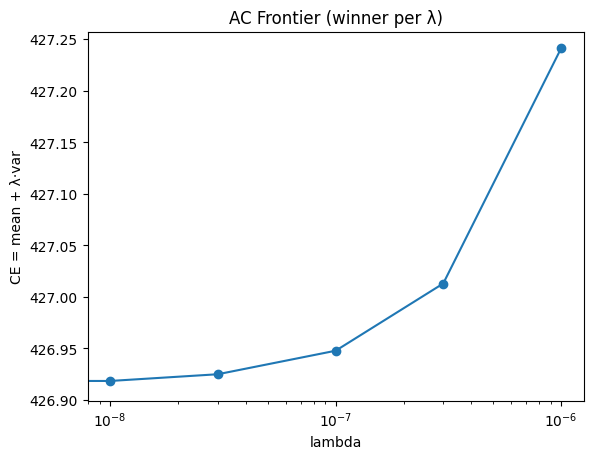

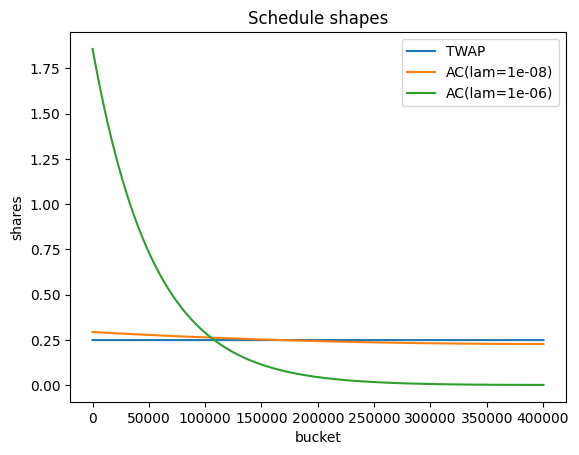

In [ ]:
import matplotlib.pyplot as plt


OUT = Path("data"); OUT.mkdir(exist_ok=True)
res_df.to_csv(OUT/"ac_frontier_results.csv", index=False)
winners.to_csv(OUT/"ac_frontier_winners.csv", index=False)
print("Saved:", OUT/"ac_frontier_results.csv", "and", OUT/"ac_frontier_winners.csv")


plt.figure(); 
plt.plot(winners["lam"], winners["CE"], marker="o"); 
plt.xscale("log"); plt.xlabel("lambda"); plt.ylabel("CE = mean + λ·var"); 
plt.title("AC Frontier (winner per λ)"); plt.show()


plt.figure()
pick = [ "TWAP", f"AC(lam={LAMBDAS[0]:g})", f"AC(lam={LAMBDAS[-1]:g})" ]
for name in pick:
    plt.plot(scheds[name], label=name)
plt.legend(); plt.xlabel("bucket"); plt.ylabel("shares"); plt.title("Schedule shapes"); plt.show()


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path as _Path

Path = _Path

PROJECT_ROOT = Path.cwd().parents[0]
MSG_DIR = PROJECT_ROOT / "data/raw/itch/AAPL"
cands = sorted(MSG_DIR.glob("*message*.csv"))
assert cands, f"No message files found under {MSG_DIR}"
MSG_PATH = cands[0]  
print("Using messages file:", MSG_PATH)

m = pd.read_csv(
    MSG_PATH, header=None,
    names=["time_s","type","order_id","size","price","dir"]
)

execs = m[m["type"].isin([4, 5])].copy()

base = pd.Timestamp("1970-01-01", tz="UTC")
execs["ts"] = base + pd.to_timedelta(execs["time_s"].astype(float), unit="s")
execs = execs.sort_values("ts").set_index("ts")

vol_1s = (
    execs["size"].astype(float).resample("1s").sum()
    .rename("vol").reset_index().rename(columns={"ts": "time"})
)

if not pd.api.types.is_datetime64_any_dtype(df["time"]):
    s = pd.to_numeric(df["time"], errors="coerce")
    df["time"] = base + pd.to_timedelta(s, unit="s")
else:
    if df["time"].dt.tz is None:
        df["time"] = df["time"].dt.tz_localize("UTC")

df = (
    df.drop(columns=["vol"], errors="ignore")
      .merge(vol_1s[["time","vol"]], on="time", how="left")
)
df["vol"] = df["vol"].fillna(0.0)

print("Merged ITCH volume ✓  rows:", len(df), "  total vol:", float(df["vol"].sum()))
print(df[["time","price_mid","vol"]].head(3))


Using messages file: /Users/krithiktoure/Desktop/DS Project 2/exec-engine/data/raw/itch/AAPL/AAPL_2012-06-21_34200000_57600000_message_10.csv
Merged ITCH volume ✓  rows: 400391   total vol: 0.0
                                 time  price_mid  vol
0 1970-01-01 09:30:00.004241176+00:00    585.635  0.0
1 1970-01-01 09:30:00.004260640+00:00    585.635  0.0
2 1970-01-01 09:30:00.004447484+00:00    585.635  0.0


In [ ]:
import pandas as pd
import numpy as np

base = pd.Timestamp("1970-01-01", tz="UTC")

if not pd.api.types.is_datetime64_any_dtype(df["time"]):
    s = pd.to_numeric(df["time"], errors="coerce")
    df["time"] = base + pd.to_timedelta(s, unit="s")
elif df["time"].dt.tz is None:
    df["time"] = df["time"].dt.tz_localize("UTC")

if not pd.api.types.is_datetime64_any_dtype(vol_1s["time"]):
    vol_1s["time"] = pd.to_datetime(vol_1s["time"], utc=True, errors="coerce")
elif vol_1s["time"].dt.tz is None:
    vol_1s["time"] = vol_1s["time"].dt.tz_localize("UTC")

df["time_1s"] = df["time"].dt.floor("1s")
vol_1s["time_1s"] = vol_1s["time"]  

df = (
    df.drop(columns=["vol"], errors="ignore")
      .merge(vol_1s[["time_1s","vol"]], on="time_1s", how="left")
      .drop(columns=["time_1s"])
)

df["vol"] = df["vol"].fillna(0.0)
print("Merged ITCH volume ✓  rows:", len(df), "  total vol:", float(df["vol"].sum()))
print(df[["time","price_mid","vol"]].head(3))

vols = df["vol"].to_numpy(float)
Q = 100_000.0
n = len(df)

scheds = {"TWAP": twap_schedule(Q, n)}
for lam in LAMBDAS:
    u = ac_discrete_schedule(Q, n, DT, sigma=SIGMA, eta=ETA, lam=lam)
    u = apply_pov_cap(u, vols, MAX_POV)
    scheds[f"AC(lam={lam:g})"] = u


Merged ITCH volume ✓  rows: 400391   total vol: 203006326.0
                                 time  price_mid     vol
0 1970-01-01 09:30:00.004241176+00:00    585.635  1038.0
1 1970-01-01 09:30:00.004260640+00:00    585.635  1038.0
2 1970-01-01 09:30:00.004447484+00:00    585.635  1038.0


In [ ]:
import pandas as pd

assert pd.api.types.is_datetime64_any_dtype(df["time"]), "df['time'] should be datetime by now"

df["_time_1s"] = df["time"].dt.floor("1s")

df_1s = (
    df.groupby("_time_1s", as_index=False)
      .agg(price_mid=("price_mid", "last"),
           vol=("vol", "sum"))
      .rename(columns={"_time_1s":"time"})
      .sort_values("time")
      .reset_index(drop=True)
)
df_1s.insert(0, "t", np.arange(len(df_1s), dtype=int))
df = df_1s

print("Collapsed to 1s:", df.shape, "  sample:")
print(df.head(5))


Collapsed to 1s: (21031, 4)   sample:
   t                      time  price_mid       vol
0  0 1970-01-01 09:30:00+00:00    585.805  107952.0
1  1 1970-01-01 09:30:01+00:00    585.620   80262.0
2  2 1970-01-01 09:30:02+00:00    585.575   18480.0
3  3 1970-01-01 09:30:03+00:00    585.580    8400.0
4  4 1970-01-01 09:30:04+00:00    585.590       0.0


In [39]:
SIGMA = realized_sigma_from_mid(df["price_mid"].values, dt=DT)
print("sigma:", SIGMA)


sigma: 6.36518291740782e-05


Saved: data/ac_frontier_results.csv and data/ac_frontier_winners.csv


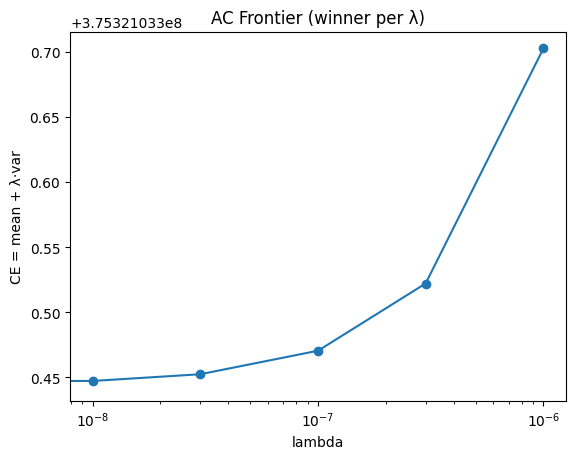

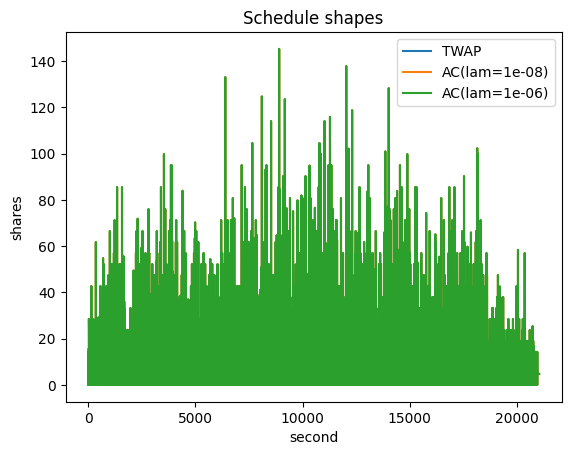

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path

MC = 64  

def evaluate_schedule(u, trials=MC, seed=SEED):
    rs = np.random.RandomState(seed)
    p0 = float(df["price_mid"].iloc[0])
    samples = []
    for _ in range(trials):
        s = int(rs.randint(0, 2**31-1))
        _, totals = simulate_exec_fast(p0=p0, u=u, dt=DT, sigma=SIGMA, eta=ETA, gamma=GAMMA, seed=s)
        samples.append(totals["IS"])
    arr = np.asarray(samples)
    return {"mean": float(arr.mean()), "var": float(arr.var(ddof=1)), "std": float(arr.std(ddof=1))}, arr

rows, dists = [], {}
for name, u in scheds.items():
    stats, smp = evaluate_schedule(u)
    dists[name] = smp
    for lam in [0.0] + LAMBDAS:
        ce = stats["mean"] + lam * stats["var"]
        rows.append({"schedule": name, "lam": lam, **stats, "CE": ce})

res_df = pd.DataFrame(rows).sort_values(["lam","CE"]).reset_index(drop=True)
winners = res_df.loc[res_df.groupby("lam")["CE"].idxmin()].reset_index(drop=True)

OUT = Path("data"); OUT.mkdir(exist_ok=True)
res_df.to_csv(OUT / "ac_frontier_results.csv", index=False)
winners.to_csv(OUT / "ac_frontier_winners.csv", index=False)
print("Saved:", OUT/"ac_frontier_results.csv", "and", OUT/"ac_frontier_winners.csv")


plt.figure()
plt.plot(winners["lam"], winners["CE"], marker="o")
plt.xscale("log"); plt.xlabel("lambda"); plt.ylabel("CE = mean + λ·var")
plt.title("AC Frontier (winner per λ)"); plt.show()


plt.figure()
pick = ["TWAP", f"AC(lam={LAMBDAS[0]:g})", f"AC(lam={LAMBDAS[-1]:g})"]
for name in pick:
    plt.plot(scheds[name], label=name)
plt.legend(); plt.xlabel("second"); plt.ylabel("shares")
plt.title("Schedule shapes"); plt.show()


In [43]:
vols = df["vol"].to_numpy(float)
cap = MAX_POV * vols
cap_total = cap.sum()
assert cap_total + 1e-9 >= 100_000.0, (
    f"PoV infeasible: sum(MAX_POV*vol)={cap_total:.1f} < Q=100000. "
    "Increase MAX_POV or reduce Q."
)


Q = 100_000.0
n = len(df)

scheds = {}

twap = twap_schedule(Q, n)
twap = apply_pov_cap(twap, vols, MAX_POV)   
scheds["TWAP"] = twap

for lam in LAMBDAS:
    u = ac_discrete_schedule(Q, n, DT, sigma=SIGMA, eta=ETA, lam=lam)
    u = apply_pov_cap(u, vols, MAX_POV)      
    scheds[f"AC(lam={lam:g})"] = u


assert all(len(u)==n and abs(u.sum()-Q) < 1e-6 for u in scheds.values())
mask = vols > 0
for name, u in scheds.items():
    assert np.all(u[mask] <= cap[mask] + 1e-9), f"PoV breach: {name}"

print("Schedules ready ✓  (TWAP and AC capped to PoV).")

Schedules ready ✓  (TWAP and AC capped to PoV).


In [ ]:
assert SIGMA > 0, "sigma is zero"
n = len(df)
for name, u in scheds.items():
    assert len(u) == n, f"{name}: length mismatch"
    assert abs(u.sum() - 100_000.0) < 1e-6, f"{name}: sum!=Q"
mask = df["vol"].to_numpy(float) > 0
for name, u in scheds.items():
    assert np.all(u[mask] <= MAX_POV * df["vol"].to_numpy(float)[mask] + 1e-9), f"PoV breach: {name}"
print("Sanity checks ✓")


Sanity checks ✓


In [ ]:
import importlib
import src.execution.simulator as sim
import src.backtest as bt


def _simulate_exec_fast(p0, u, dt, sigma, eta, gamma, seed=42):
    rs = np.random.RandomState(seed)
    u = np.asarray(u, dtype=float)
    n = len(u)

    z = rs.normal(0.0, 1.0, size=n)
    base = np.empty(n + 1, dtype=float)
    base[0] = p0
    base[1:] = p0 + np.cumsum(sigma * np.sqrt(dt) * z)

    csum_u = np.cumsum(u)
    perm_shift = np.r_[0.0, csum_u[:-1]] * (gamma / dt)
    mid = base.copy()
    mid[1:] += perm_shift

    exec_px = mid[:-1] + (gamma * u) / (2.0 * dt) + (eta * u) / dt

    Q = float(u.sum())
    is_cost = float(np.dot(u, exec_px) - Q * p0)

    out = pd.DataFrame({
        "t": np.arange(n, dtype=int),
        "u": u,
        "mid_t": mid[:-1],
        "mid_t1": mid[1:],
        "exec_px": exec_px,
    })
    totals = {"Q": Q, "p0": p0, "IS": is_cost}
    return out, totals


sim.simulate_exec_fast = _simulate_exec_fast


bt = importlib.reload(bt)

bt_res, bt_win = bt.run_backtest(
    df,
    q_for_spread=locals().get("q", None),
    k=3, Q=100_000.0, DT=DT,
    LAMBDAS=LAMBDAS, MAX_POV=MAX_POV,
    mc=64, seed=SEED,
)

print("Backtest rows:", len(bt_res))
display(bt_res.head(10))
print("Winners per fold & λ:")
display(bt_win)


Backtest rows: 108


,fold,t_start,t_end,schedule,lam,mean,std,var,CE,Q_eff,SIG,ETA,GAMMA
0,1,0,7010,AC(lam=3e-08),0.000000e+00,3.811251e+08,6.007584e-08,3.609106e-15,3.811251e+08,100000.0,0.0,0.75,0.075
1,1,0,7010,AC(lam=3e-07),0.000000e+00,3.811251e+08,0.000000e+00,0.000000e+00,3.811251e+08,100000.0,0.0,0.75,0.075
2,1,0,7010,AC(lam=1e-06),0.000000e+00,3.811251e+08,0.000000e+00,0.000000e+00,3.811251e+08,100000.0,0.0,0.75,0.075
3,1,0,7010,AC(lam=1e-07),0.000000e+00,3.811251e+08,6.007584e-08,3.609106e-15,3.811251e+08,100000.0,0.0,0.75,0.075
4,1,0,7010,AC(lam=1e-08),0.000000e+00,3.811251e+08,6.007584e-08,3.609106e-15,3.811251e+08,100000.0,0.0,0.75,0.075
5,1,0,7010,TWAP,0.000000e+00,3.811251e+08,0.000000e+00,0.000000e+00,3.811251e+08,100000.0,0.0,0.75,0.075
6,1,0,7010,AC(lam=3e-08),1.000000e-08,3.811251e+08,6.007584e-08,3.609106e-15,3.811251e+08,100000.0,0.0,0.75,0.075
7,1,0,7010,AC(lam=3e-07),1.000000e-08,3.811251e+08,0.000000e+00,0.000000e+00,3.811251e+08,100000.0,0.0,0.75,0.075
8,1,0,7010,AC(lam=1e-06),1.000000e-08,3.811251e+08,0.000000e+00,0.000000e+00,3.811251e+08,100000.0,0.0,0.75,0.075
9,1,0,7010,AC(lam=1e-07),1.000000e-08,3.811251e+08,6.007584e-08,3.609106e-15,3.811251e+08,100000.0,0.0,0.75,0.075


Winners per fold & λ:


,fold,t_start,t_end,schedule,lam,mean,std,var,CE,Q_eff,SIG,ETA,GAMMA
0,1,0,7010,AC(lam=3e-08),0.000000e+00,3.811251e+08,6.007584e-08,3.609106e-15,3.811251e+08,100000.0,0.000000,0.75,0.075
1,1,0,7010,AC(lam=3e-08),1.000000e-08,3.811251e+08,6.007584e-08,3.609106e-15,3.811251e+08,100000.0,0.000000,0.75,0.075
2,1,0,7010,AC(lam=3e-08),3.000000e-08,3.811251e+08,6.007584e-08,3.609106e-15,3.811251e+08,100000.0,0.000000,0.75,0.075
3,1,0,7010,AC(lam=3e-08),1.000000e-07,3.811251e+08,6.007584e-08,3.609106e-15,3.811251e+08,100000.0,0.000000,0.75,0.075
4,1,0,7010,AC(lam=3e-08),3.000000e-07,3.811251e+08,6.007584e-08,3.609106e-15,3.811251e+08,100000.0,0.000000,0.75,0.075
5,1,0,7010,AC(lam=3e-08),1.000000e-06,3.811251e+08,6.007584e-08,3.609106e-15,3.811251e+08,100000.0,0.000000,0.75,0.075
6,2,7011,14021,AC(lam=1e-06),0.000000e+00,3.836908e+08,3.475724e+02,1.208066e+05,3.836908e+08,100000.0,0.000077,0.75,0.075
7,2,7011,14021,AC(lam=1e-06),1.000000e-08,3.836908e+08,3.475724e+02,1.208066e+05,3.836908e+08,100000.0,0.000077,0.75,0.075
8,2,7011,14021,AC(lam=1e-06),3.000000e-08,3.836908e+08,3.475724e+02,1.208066e+05,3.836908e+08,100000.0,0.000077,0.75,0.075
9,2,7011,14021,AC(lam=1e-06),1.000000e-07,3.836908e+08,3.475724e+02,1.208066e+05,3.836908e+08,100000.0,0.000077,0.75,0.075


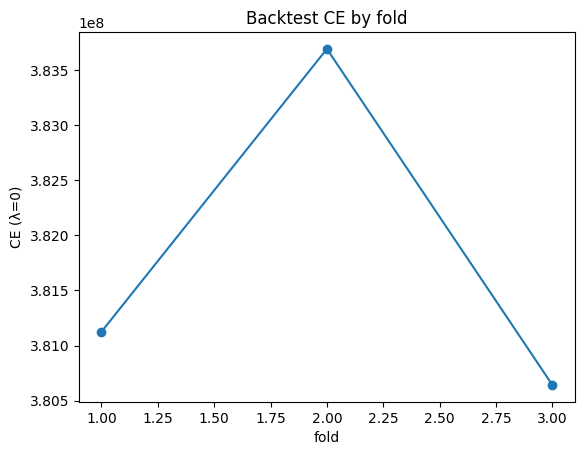

AC beat TWAP in 66.7% of folds (λ=0).


In [57]:
import matplotlib.pyplot as plt
subset = bt_win[bt_win["lam"] == 0.0]
plt.figure(); plt.plot(subset["fold"], subset["CE"], marker="o")
plt.xlabel("fold"); plt.ylabel("CE (λ=0)"); plt.title("Backtest CE by fold"); plt.show()
print("AC beat TWAP in %.1f%% of folds (λ=0)." % (100*(subset["schedule"]!="TWAP").mean()))
